# Next-Frame Video Prediction with Convolutional LSTMs using Circle Dataset

https://keras.io/examples/vision/conv_lstm/ 



İmporting Necessary Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
import torch
import io
import imageio
import cv2
import os
import numpy as np
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
device_name = tensorflow.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Getting Dataset into an array

In [ ]:
dataset = np.zeros((1000, 20, 80, 80, 3), dtype=np.float)
dir='/content/drive/MyDrive/circle_videos/circle_'
for i in range(0,1000):
  frames=[]
  print(dir+str(i+1)+".mp4")
  vidcap = cv2.VideoCapture(dir+str(i+1)+".mp4")
  for count in range(0,20):
    success,image = vidcap.read()
    dataset[i,count,::,::,::]=image


In [ ]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 256s 1s/step - loss: 0.6811 - val_loss: 0.6926
Epoch 2/20
180/180 [==============================] - 220s 1s/step - loss: 0.6769 - val_loss: 0.6908
Epoch 3/20
180/180 [==============================] - 219s 1s/step - loss: 0.6767 - val_loss: 0.6873
Epoch 4/20
180/180 [==============================] - 220s 1s/step - loss: 0.6766 - val_loss: 0.6801
Epoch 5/20
180/180 [==============================] - 218s 1s/step - loss: 0.6766 - val_loss: 0.6773
Epoch 6/20
180/180 [==============================] - 220s 1s/step - loss: 0.6765 - val_loss: 0.6767
Epoch 7/20
180/180 [==============================] - 219s 1s/step - loss: 0.6765 - val_loss: 0.6767
Epoch 8/20
180/180 [==============================] - 218s 1s/step - loss: 0.6765 - val_loss: 0.6767
Epoch 9/20
180/180 [==============================] - 218s 1s/step - loss: 0.6765 - val_loss: 0.6766
Epoch 10/20
180/180 [==============================] - 220s 1s/step - loss: 0.6764 - val_lo

## Save and load model

In [ ]:
model.save('/content/drive/MyDrive/saved_models/convlstm_circle_ready.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/saved_models/convlstm_circle_ready.h5')

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

In [ ]:
data=[]
vidcap = cv2.VideoCapture('/content/circle_1004.mp4')
for count in range(0,96):
  success,image = vidcap.read()
  data.append(image)
data=np.array(data)
data = data/255

In [ ]:
# Select a few random examples from the dataset.
#examples = [data]
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]
# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[50:60, ...]
    original_frames = example[60:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))
    count=0
    for f in original_frames:
      plt.imsave('/content/drive/MyDrive/new_conv_lstm_circle_predictions/orig_'+str(count)+'.png',f)
      count+=1

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[50:60 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    count=0
    for f in new_predictions:
      plt.imsave('/content/drive/MyDrive/new_conv_lstm_circle_predictions/predict_'+str(count)+'.png',f)
      count+=1

      

<Figure size 720x1080 with 0 Axes>

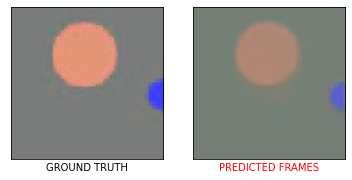

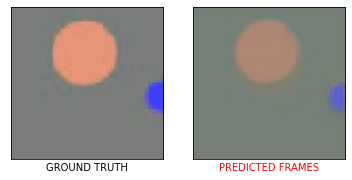

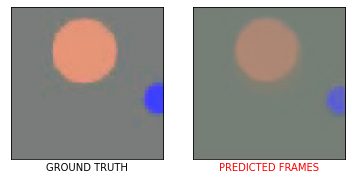

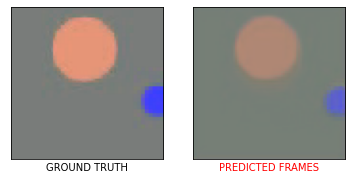

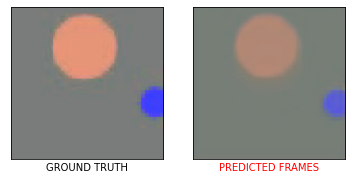

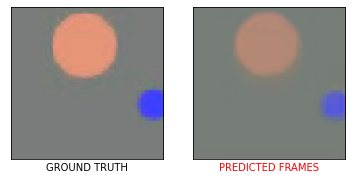

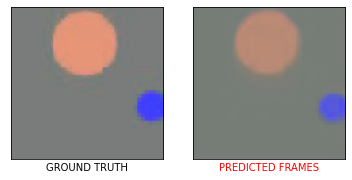

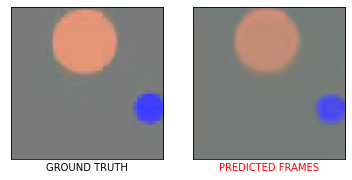

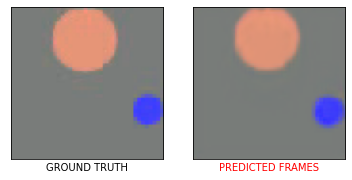

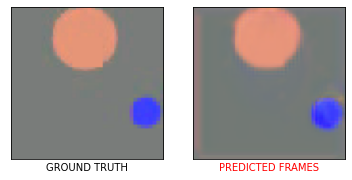

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Plot comparison
fig=plt.figure(figsize=(10, 15))
for i in range(10):
  ground_truth = Image.open('/content/drive/MyDrive/new_conv_lstm_circle_predictions/orig_'+str(i)+'.png')
  predictions = Image.open('/content/drive/MyDrive/new_conv_lstm_circle_predictions/predict_'+str(i)+'.png')
  f, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(ground_truth)
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_xlabel('GROUND TRUTH')
  ax2.imshow(predictions)
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xlabel('PREDICTED FRAMES', color='r')
  f.savefig('/content/drive/MyDrive/new_conv_lstm_circle_predictions/comparison'+str(i)+'.png', tight=True)

## Creating video from predicted frames

In [ ]:
import cv2
import numpy as np
from cv2 import VideoWriter, VideoWriter_fourcc
width = 432
height = 288
width2 = 80
height2 = 80
FPS = 5 #Saniyedeki frame sayısı azaltılarak saniye artırılabilir.
fourcc = VideoWriter_fourcc(*'mp4v')
name='/content/drive/MyDrive/predicted_videos/newconvlstmcircle_comparison.mp4'
name2='/content/drive/MyDrive/predicted_videos/newconvlstmcircle_predicted.mp4'
video = VideoWriter(name, fourcc, float(FPS), (width, height))
video2 = VideoWriter(name2, fourcc, float(FPS), (width2, height2))
for i in range(10):
  img = cv2.imread('/content/drive/MyDrive/new_conv_lstm_circle_predictions/comparison{}.png'.format(i))
  video.write(img)
  img2 = cv2.imread('/content/drive/MyDrive/new_conv_lstm_circle_predictions/predict_{}.png'.format(i))
  video2.write(img2)
video.release()
video2.release()